In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
from SNN import SNNetwork
from utils.training_multi_utils import *
from utils.training_utils import *
from utils.inference_utils import *
from plot_snn.eval import *
import time
import numpy as np
import tables
import math
import argparse
import os
import matplotlib.pyplot as plt
import pdb
from torch.utils.tensorboard import SummaryWriter
import datetime
import scipy.misc
from scipy import ndimage

In [2]:
# task-prediction_digits-5_ex-single_dec-single_eptrain-5_eptest-3_mode-iw_niter-1
# _Nh-2_Nk-5_lr-0.05_lrconst-1.0_kappa-0.05_Nb-3_nll-5_time-03260001_t-400.pth

task = 'prediction'
digits_ = 2
train_indices_mode = 'single'
dec_type = 'single'
epochs = 5
epochs_test = 3
mode_ = 'iw'
niter = 1
n_hidden_neurons = 2
num_samples = 5
learning_rate = 0.05
lr_const = 1.0
kappa = 0.05
n_basis = 3
num_ll_est = 5
current_time = '03260002'
time_range = ['03260000', '03262359']
timestep = [80, 160, 240, 320, 400]


query_hprof_t = { 
'task': str(task),
'digits': str(digits_),
'ex': str(train_indices_mode),
'dec': str(dec_type),
'eptrain': str(epochs),
'eptest': str(epochs_test),
'mode': str(mode_),
'Nh': str(n_hidden_neurons),
'Nk': str(num_samples),
'lr': str(learning_rate),
'lrconst': str(lr_const),
'kappa': str(kappa),
'Nb': str(n_basis),
'nll': str(num_ll_est),
'time': str(current_time)
}

query_hprof_Nk = { 
'task': str(task),
'digits': str(digits_),
'ex': str(train_indices_mode),
'dec': str(dec_type),
'eptrain': str(epochs),
'eptest': str(epochs_test),
'mode': str(mode_),
'Nh': str(n_hidden_neurons),
'Nk': str(num_samples),
'lr': str(learning_rate),
'lrconst': str(lr_const),
'kappa': str(kappa),
'Nb': str(n_basis),
'nll': str(num_ll_est),
'time': str(current_time)
}

# sweep_mode 
sweep_t = {'hyperparam': 't', 'value': timestep}
sweep_Nk = {'hyperparam':'Nk','value': [1,5]}

# Inference on Training dataset
inference_metrics = ['loss_bound', 'distance_avg']


In [3]:
# random seed 
torch.manual_seed(1)
np.random.seed(1)   
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(1)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
if digits_ == 2:
    digits = [1,7]
elif digits_ <= 10:
    digits = [i for i in range(digits_)]
else:
    digits = [i for i in range(10)]

dataset = r'../datasets/mnist-dvs/mnist_dvs_25ms_26pxl_10_digits_C_1.hdf5'
data = tables.open_file(dataset)

input_train_total = torch.FloatTensor(data.root.train.data[:])
output_train_total = torch.FloatTensor(data.root.train.label[:])

input_test_total = torch.FloatTensor(data.root.test.data[:])
output_test_total = torch.FloatTensor(data.root.test.label[:])

indices_train = np.hstack([np.where(np.argmax(np.sum(data.root.train.label[:], axis=(-1, -2)), axis=-1) == i)[0] for i in digits])
input_train = input_train_total[indices_train]
output_train = output_train_total[indices_train]
output_train = output_train[:,digits]

test_indices = np.hstack([np.where(np.argmax(np.sum(data.root.test.label[:], axis=(-1, -2)), axis=-1) == i)[0] for i in digits])
input_test = input_test_total[test_indices]
output_test = output_test_total[test_indices]
output_test = output_test[:,digits]
 
# for prediction
if task == 'prediction':
    input_train_old = input_train
    input_test_old = input_test
    img_size = int(np.sqrt(input_train.shape[1]))

    input_idx = np.arange(input_train_old.shape[1]).reshape((img_size, img_size))[:,np.arange(int(img_size/2))].reshape(-1)
    output_idx = np.arange(input_train_old.shape[1]).reshape((img_size, img_size))[:,int(img_size/2):].reshape(-1)

    input_train = input_train_old[:, input_idx, :, :]
    output_train = input_train_old[:, output_idx, :, :]
    input_test = input_test_old[:, input_idx, :, :]
    output_test = input_test_old[:, output_idx, :, :]
    
# Randomly select training/testing samples
if train_indices_mode == 'single':
    indices = np.random.choice(np.arange(1), [epochs], replace=True)
elif train_indices_mode == 'multiple':
    n_ref = int(epochs/len(digits))
    list_ref = []
    for i in range(len(digits)):
        list_ref = np.append( list_ref, np.random.choice(np.arange( int(input_train.shape[0]/len(digits))*(i), int(input_train.shape[0]/len(digits))*(i)+5 ), [n_ref], replace=True) )
    indices = np.random.permutation(list_ref)
    #indices = np.random.permutation(np.append( np.random.choice(np.arange(5), [int(epochs/2)], replace=True), np.random.choice(np.arange(input_train.shape[0]/2, input_train.shape[0]/2+5), [int(epochs/2)], replace=True)  ))
else:
    if epochs > input_train.shape[0]:
        indices = np.random.choice(np.arange(input_train.shape[0]), [epochs], replace=True)    
    else:
        indices = np.random.choice(np.arange(input_train.shape[0]), [epochs], replace=False)    

if epochs_test > input_test.shape[0]:
    test_indices = np.random.choice(np.arange(input_test.shape[0]), [epochs_test], replace=True)
else:
    test_indices = np.random.choice(np.arange(input_test.shape[0]), [epochs_test], replace=False)

print(indices)

print('Task %s - Nh %d, Nk %d, lr %4.3f kappa %3.2f, Nbasis %d' \
    %(task, n_hidden_neurons, num_samples, learning_rate, kappa, n_basis), flush=True)

if mode_ == 'mb':
    mode = 'train_ml_multi_elbo'
elif mode_ == 'iw':
    mode = 'train_ml_multi'
elif mode_ == 'iwb':
    mode = 'train_ml_multi_ls'
elif mode_ == 'gem':
    mode = 'train_ml_multi_nols'
elif mode_ == 'mb1':
    mode = 'train_ml'

[0 0 0 0 0]
Task prediction - Nh 2, Nk 5, lr 0.050 kappa 0.05, Nbasis 3


In [5]:
results_path = 'results'
hprof_file_list = get_hprofs_from_files(results_path)
len(hprof_file_list)

108

Inference performance on training dataset
done with get_inference_from_hprof
done with get_inference_from_hprof
done with get_inference_from_hprof
done with get_inference_from_hprof
done with get_inference_from_hprof
loss_bound: t_80, -3994.651245 +- 86.477623
loss_bound: t_160, -1700.401794 +- 11.172448
loss_bound: t_240, -923.664948 +- 13.073067
loss_bound: t_320, -566.973907 +- 0.896447
loss_bound: t_400, -437.546738 +- 3.961263
 
distance_avg: t_80, 0.112882 +- 0.000216
distance_avg: t_160, 0.051114 +- 0.000133
distance_avg: t_240, 0.033819 +- 0.000210
distance_avg: t_320, 0.021797 +- 0.000133
distance_avg: t_400, 0.016639 +- 0.000162
 


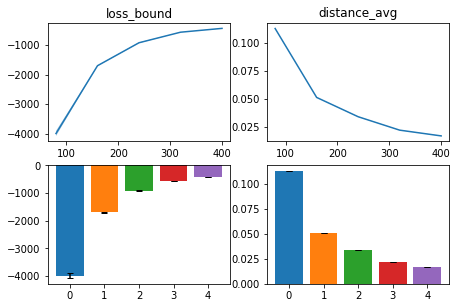

Number of samples for inference: 5, time: 226.310642


In [6]:
print('Inference performance on training dataset', flush=True)
t0 = time.time()
get_inference_eval(hprof_file_list, sweep_t, inference_metrics, query_hprof_t, input_train[indices], output_train[indices], time_range)
print('Number of samples for inference: %d, time: %f' % (epochs, time.time() - t0), flush=True)

loss_output_train: Nk_1, -461.691269 +- 14.745737
loss_output_train: Nk_5, -418.709305 +- 4.531952
spikenum_hid_train: Nk_1, 102.500000 +- 22.867833
spikenum_hid_train: Nk_5, 403.500000 +- 312.527055


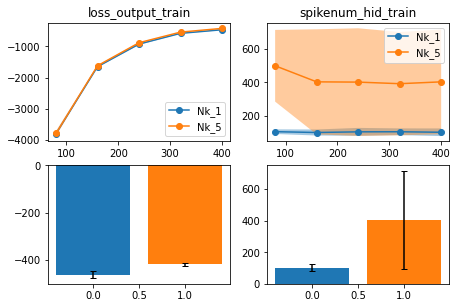

0

In [7]:
metrics = ['loss_output_train', 'spikenum_hid_train']

get_result(hprof_file_list, sweep_Nk, metrics, query_hprof_Nk, time_range)

In [8]:
metrics = ['loss_output_test_f', 'spikenum_hid_test_inference']

get_result(hprof_file_list, sweep_Nk, metrics, query_hprof_t, time_range)

KeyError: 'loss_output_test_f'